In [1]:
from typing import Union, Optional
from dataclasses import dataclass
import math

import tensorflow as tf
import numpy as np
import PIL.Image as Image

In [2]:
tf.__version__

'2.7.0'

In [3]:
lena = Image.open("imgs/Lenna512.png")
chess = Image.open("imgs/ChessSet512.png")
imgs = [np.array(i) / 255.0 for i in [lena, chess]]
imgs

[array([[[0.87843137, 0.51372549, 0.42352941],
         [0.8745098 , 0.50980392, 0.42352941],
         [0.87058824, 0.52156863, 0.43529412],
         ...,
         [0.81568627, 0.39607843, 0.36862745],
         [0.78823529, 0.36078431, 0.32941176],
         [0.72156863, 0.30980392, 0.31764706]],
 
        [[0.88235294, 0.51372549, 0.41960784],
         [0.8745098 , 0.51372549, 0.41960784],
         [0.8745098 , 0.5254902 , 0.43137255],
         ...,
         [0.78823529, 0.38039216, 0.36078431],
         [0.74117647, 0.31372549, 0.30980392],
         [0.62745098, 0.21568627, 0.26666667]],
 
        [[0.88235294, 0.51764706, 0.41960784],
         [0.8745098 , 0.51764706, 0.41568627],
         [0.8745098 , 0.52156863, 0.42352941],
         ...,
         [0.74509804, 0.3372549 , 0.34901961],
         [0.6627451 , 0.25882353, 0.30588235],
         [0.54117647, 0.14117647, 0.24313725]],
 
        ...,
 
        [[0.31764706, 0.08235294, 0.23137255],
         [0.32156863, 0.07843137, 0.22745

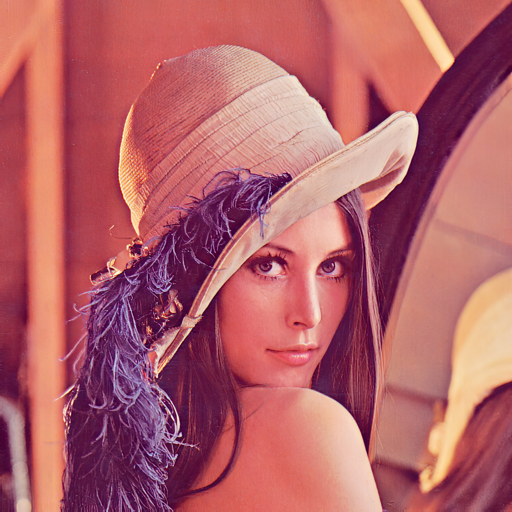

In [4]:
lena

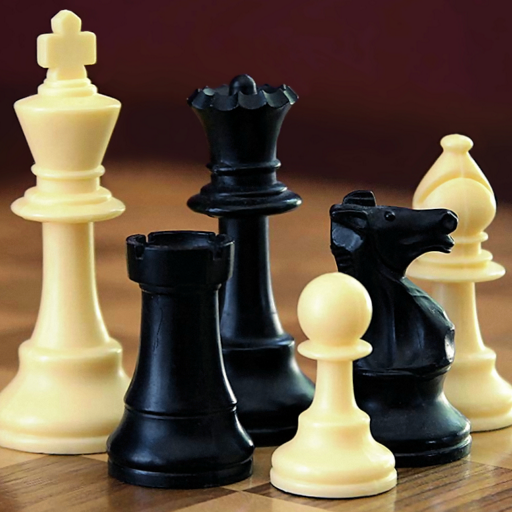

In [5]:
chess

In [6]:
def make_gauss_blur_kernel(size: int, sigma: float = 2) -> np.ndarray:
    result = np.zeros(shape=[size], dtype=float)
    center = (size - 1) // 2
    div = 2 * (sigma ** 2)
    for i in range(size):
        x2 = (center - i)**2
        result[i] = math.exp( -x2 / div)
    return result / np.sum(result)

make_gauss_blur_kernel(size=11, sigma=2)

array([0.00881223, 0.02714358, 0.06511406, 0.12164907, 0.17699836,
       0.20056541, 0.17699836, 0.12164907, 0.06511406, 0.02714358,
       0.00881223])

In [7]:
@dataclass
class Report:
    image: np.ndarray
    gradient: np.ndarray
    image_source: np.ndarray
    loss_precise: float
    loss_gauss: float
    loss: float

class MyModel:
    def __init__(self, img_h: int, img_w: int, gauss_kernel_size: int, gauss_sigma: float, image_source: Optional[np.ndarray] = None):
        if image_source is None:
            image_source = np.zeros(shape=(1, img_h, img_w, 3), dtype=float)
        self.trainable_image = tf.Variable(initial_value=image_source, trainable=True)
        gauss_blur_kernel = make_gauss_blur_kernel(gauss_kernel_size, gauss_sigma)
        self.gauss_kernel_x = tf.constant(gauss_blur_kernel[np.newaxis, :, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))
        self.gauss_kernel_y = tf.constant(gauss_blur_kernel[:, np.newaxis, np.newaxis, np.newaxis] * np.ones(shape=(1, 1, 3, 1)))

    def run(self, img_precise: np.ndarray, img_blurred: np.ndarray, m_precise = 1, m_blurred = 1) -> Report:
        with tf.GradientTape() as tape:
            trainable_image01 = tf.math.sigmoid(self.trainable_image)
            ## precise
            loss_precise = tf.reduce_sum(tf.square(trainable_image01 - img_precise[np.newaxis, :, :, :]))
            ## do gamma-correction, gaussian blur and inverted gamma-correction
            blurred = self.gauss_blur(trainable_image01 ** 2.2) ** (1.0 / 2.2)
            blurred_label = self.gauss_blur(img_blurred[np.newaxis, :, :, :] ** 2.2) ** (1.0 / 2.2)
            loss_gauss = tf.reduce_sum(tf.square(blurred - blurred_label))

            loss = loss_precise * m_precise + loss_gauss * m_blurred
        gradient = tape.gradient(loss, self.trainable_image)
        return Report(
            image=trainable_image01.numpy()[0],
            gradient=gradient.numpy(),
            image_source=self.trainable_image.numpy(),
            loss_precise=loss_precise.numpy(),
            loss_gauss=loss_gauss.numpy(),
            loss=loss.numpy(),
        )

    def apply_gradient(self, grad: np.ndarray, lr: float):
        self.trainable_image.assign(self.trainable_image.numpy() - lr * grad)

    def gauss_blur(self, inp: Union[tf.Tensor, np.ndarray]) -> tf.Tensor:
        r = inp
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_x, strides=[1,1,1,1], padding='SAME')
        r = tf.nn.depthwise_conv2d(r, self.gauss_kernel_y, strides=[1,1,1,1], padding='SAME')
        return r

    def train(self, steps_count: int, print_loss_steps: int, lr: float, **run_kwargs) -> Report:
        for i in range(steps_count):
            r = self.run(**run_kwargs)
            model.apply_gradient(r.gradient, lr)
            if i % print_loss_steps == print_loss_steps - 1:
                print(f"{i}: loss = {r.loss}, precise = {r.loss_precise}, gauss = {r.loss_gauss}")
        return r

49: loss = 15147.994420940573, precise = 66993.0849225125, gauss = 8448.685928689323
99: loss = 11479.071665608222, precise = 79321.91681603937, gauss = 3546.8799840042857
149: loss = 10721.70146000468, precise = 84176.3736641805, gauss = 2304.06409358663
199: loss = 10456.340705753159, precise = 86538.38695192, gauss = 1802.5020105611575


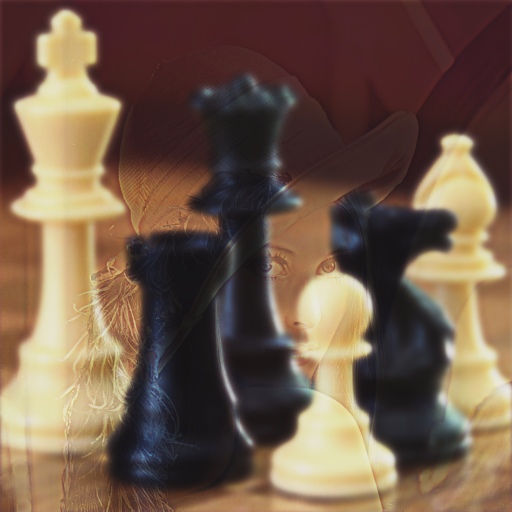

In [8]:
model = MyModel(512, 512, gauss_kernel_size=15, gauss_sigma=3)
r = model.train(steps_count=200, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=0.1, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 25706.37403160983, precise = 70925.4021266328, gauss = 4428.753393619991
99: loss = 25402.7306457838, precise = 66061.23534389182, gauss = 5584.360042616254
149: loss = 25323.26377372416, precise = 64412.56572820977, gauss = 5999.49405526123
199: loss = 25289.250980836696, precise = 63778.95233494173, gauss = 6155.565280354179
249: loss = 25269.21296738791, precise = 63506.50715027431, gauss = 6217.26082230562
299: loss = 25255.428001102715, precise = 63376.84962337655, gauss = 6242.373114089749
349: loss = 25245.198217226312, precise = 63309.20019523959, gauss = 6252.438158654437
399: loss = 25237.265172101663, precise = 63270.83734610219, gauss = 6256.013968271007
449: loss = 25230.925597668887, precise = 63247.39011752422, gauss = 6256.708562411621
499: loss = 25225.742957895553, precise = 63232.07411023396, gauss = 6256.120724825367


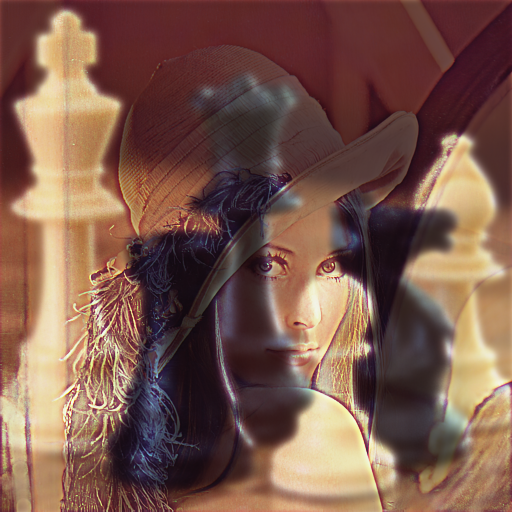

In [9]:
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=0.3, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 54675.16599766596, precise = 25324.321787482462, gauss = 29350.844210183495
99: loss = 53830.64009664126, precise = 25951.903584816147, gauss = 27878.73651182511
149: loss = 53686.35528358861, precise = 26041.048008245332, gauss = 27645.30727534328
199: loss = 53634.741292688544, precise = 26056.683848841094, gauss = 27578.057443847447
249: loss = 53609.84757714163, precise = 26059.939135940665, gauss = 27549.90844120096
299: loss = 53595.719919565905, precise = 26060.780317785164, gauss = 27534.93960178074
349: loss = 53586.82134005757, precise = 26061.163000829772, gauss = 27525.658339227797
399: loss = 53580.790190026826, precise = 26061.50407935634, gauss = 27519.286110670488
449: loss = 53576.47348254614, precise = 26061.879166062645, gauss = 27514.594316483497
499: loss = 53573.251635209745, precise = 26062.284454538218, gauss = 27510.967180671527


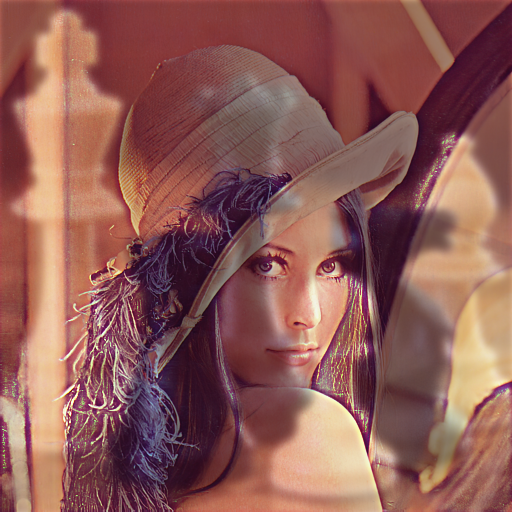

In [10]:
model = MyModel(512, 512, gauss_kernel_size=15, gauss_sigma=3)
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[0], img_blurred=imgs[1], m_precise=1.0, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 12397.611565962026, precise = 89412.91035028709, gauss = 3456.320530933317
99: loss = 10914.396469415027, precise = 92831.23061224257, gauss = 1631.2734081907706
149: loss = 10670.712381227739, precise = 94006.92655145771, gauss = 1270.0197260819677
199: loss = 10589.731638185274, precise = 94411.73637280294, gauss = 1148.5580009049788
249: loss = 10550.942185010226, precise = 94540.62963034006, gauss = 1096.8792219762192
299: loss = 10528.099183453236, precise = 94564.42439110472, gauss = 1071.6567443427634
349: loss = 10512.80708233263, precise = 94546.82411792583, gauss = 1058.1246705400472
399: loss = 10501.657324714399, precise = 94513.2368732866, gauss = 1050.3336373857383
449: loss = 10493.027210019982, precise = 94474.31580202625, gauss = 1045.5956298173562
499: loss = 10486.051353289513, precise = 94434.6482373492, gauss = 1042.5865295545923


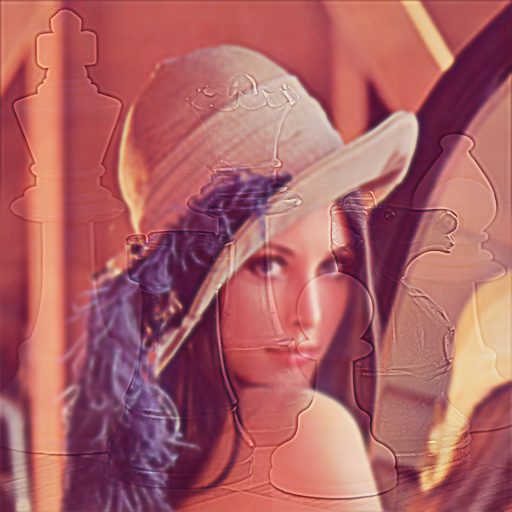

In [11]:
model = MyModel(512, 512, gauss_kernel_size=11, gauss_sigma=2)
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[1], img_blurred=imgs[0], m_precise=0.1, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))

49: loss = 12397.611565962026, precise = 89412.91035028709, gauss = 3456.320530933317
99: loss = 10914.396469415027, precise = 92831.23061224257, gauss = 1631.2734081907706
149: loss = 10670.712381227739, precise = 94006.92655145771, gauss = 1270.0197260819677
199: loss = 10589.731638185274, precise = 94411.73637280294, gauss = 1148.5580009049788
249: loss = 10550.942185010226, precise = 94540.62963034006, gauss = 1096.8792219762192
299: loss = 10528.099183453236, precise = 94564.42439110472, gauss = 1071.6567443427634
349: loss = 10512.80708233263, precise = 94546.82411792583, gauss = 1058.1246705400472
399: loss = 10501.657324714399, precise = 94513.2368732866, gauss = 1050.3336373857383
449: loss = 10493.027210019982, precise = 94474.31580202625, gauss = 1045.5956298173562
499: loss = 10486.051353289513, precise = 94434.6482373492, gauss = 1042.5865295545923


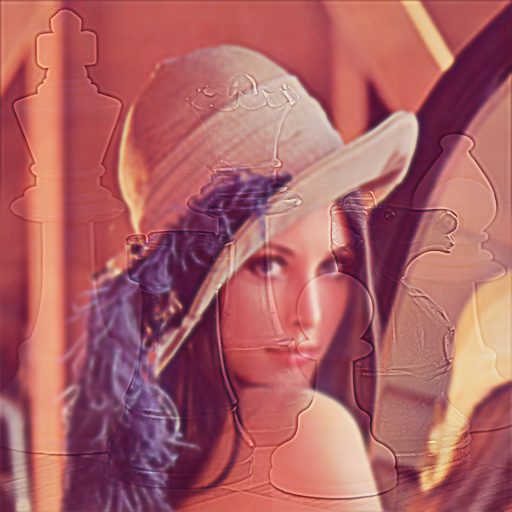

In [12]:
model = MyModel(512, 512, gauss_kernel_size=11, gauss_sigma=2)
r = model.train(steps_count=500, print_loss_steps=50, lr=0.3, img_precise=imgs[1], img_blurred=imgs[0], m_precise=0.1, m_blurred=1.0)
Image.fromarray(np.uint8(r.image * 255.0))